In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

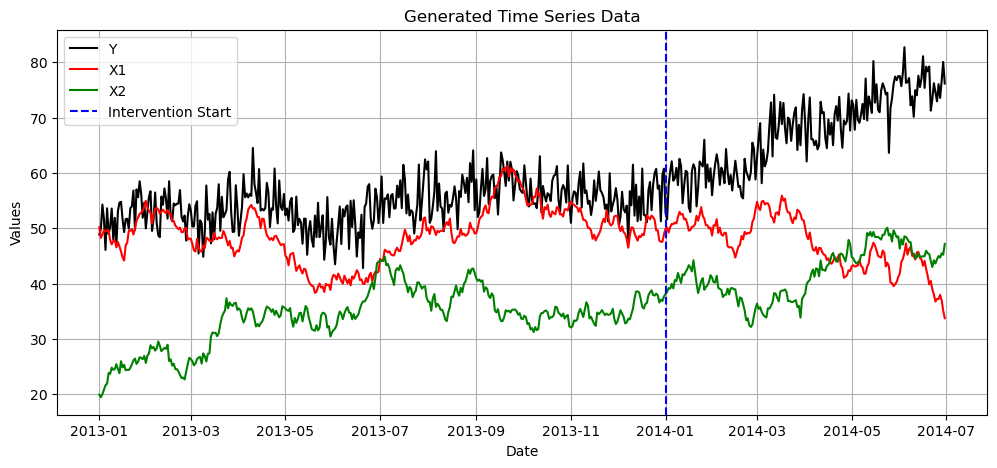

In [26]:
# Set random seed for reproducibility
np.random.seed(26)

# Create a date range
date_range = pd.date_range(start='2013-01-01', end='2014-06-30', freq='D')
N = len(date_range)

# Generate X1 and X2 as random walks
x1 = np.cumsum(np.random.normal(loc=0, scale=1, size=N)) + 50
x2 = np.cumsum(np.random.normal(loc=0, scale=1, size=N)) + 20

# Generate Y as a linear combination of X1 and X2, with added noise
y = 20 + 0.5 * x1 + 0.3 * x2 + np.random.normal(loc=0, scale=3, size=N)
y_true = y.copy()

# Introduce an intervention effect starting in 2014
intervention_start = '2014-01-01'
intervention_idx = date_range.get_loc(intervention_start)
y[intervention_idx:] += np.cumsum(np.random.normal(loc=0.1, scale=0.5, size= N - intervention_idx))

# Define the pre- and post-intervention periods
pre_intervention = slice(0, intervention_idx)
post_intervention = slice(intervention_idx, N)

# Create a DataFrame to store the data
data = pd.DataFrame({'Date': date_range, 'X1': x1, 'X2': x2, 'Y': y, 'Y_true': y_true})
data.set_index('Date', inplace=True)

# Plot the data
plt.figure(figsize=(12, 5))
plt.plot(data.index, data['Y'], label='Y', color='black')
plt.plot(data.index, data['X1'], label='X1', color='red')
plt.plot(data.index, data['X2'], label='X2', color='green')
plt.axvline(x=pd.Timestamp(intervention_start), color='blue', linestyle='--', label='Intervention Start')
plt.title('Generated Time Series Data')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

In [3]:
# Define PyMC model
with pm.Model(coords={"n": np.arange(intervention_idx)}) as state_space_model:
    # ---- Data ----
    Y = pm.Data(name="Y", value=data['Y'].values[pre_intervention], dims="n")
    X1 = pm.Data(name="X1", value=data['X1'].values[pre_intervention], dims="n")
    X2 = pm.Data(name="X2", value=data['X2'].values[pre_intervention], dims="n")

    # ---- Seasonality Component ----
    # Prior for seasonal noise variance
    # sigma_gamma = pm.HalfNormal("sigma_gamma", sigma=0.1)
    #
    # # Initialize seasonal effects (state vector) with zeros
    # gamma = pm.Normal("gamma", mu=0, sigma=1, shape=(n, S - 1))  # S-1 seasonal states
    #
    # # Transition matrix for seasonality
    # T = np.zeros((S - 1, S - 1))
    # T[0, :] = -1  # Top row with -1 values
    # for i in range(1, S - 1):  # Subdiagonal with 1s
    #     T[i, i - 1] = 1
    #
    # # State equation: Evolution of seasonal effects
    # seasonal_effect = pm.Deterministic("seasonal_effect",
    #                                     pm.math.sum(gamma, axis=1)  # Ensures shape alignment
    #                                 )

    # ---- Trend Component ----
    # Define noise variances for trend
    sigma_mu = pm.HalfNormal("sigma_mu", sigma=2)
    # sigma_delta = pm.HalfNormal("sigma_delta", sigma=1)

    # Define the trend component - mu_t
    mu = pm.GaussianRandomWalk("mu", sigma=sigma_mu, dims="n", init_dist=pm.Normal.dist(mu=0, sigma=1))

    # Define the slope component - delta_t
    # delta = pm.GaussianRandomWalk("delta", sigma=sigma_delta, dims="n", init_dist=pm.Normal.dist(mu=0, sigma=1))

    # Combine mu_t and delta_t to form the full trend for y_t
    # trend = (mu
             # + delta.cumsum()
             # )

    # ---- Regression Component ----
    # Slopes for predictors X1 and X2 (Regression Coefficients)
    beta_X1 = pm.Normal("beta_X1", mu=0, sigma=1)
    beta_X2 = pm.Normal("beta_X2", mu=0, sigma=1)

    # ---- Observation Equation ----
    # Observation noise
    sigma_obs = pm.HalfNormal("sigma_obs", sigma=1)

    # Expected value of Y_t:
    mean = pm.Deterministic(
            name="mean",
            var=(
                mu
                # + delta.cumsum()
                + X1 + beta_X1
                + X2 * beta_X2
            ),
            dims="n",
        )

    # Observation Equation (Y_t = Z_t^T alpha_t + epsilon_t)
    Y_obs = pm.Normal("Y_obs", mu=mean, sigma=sigma_obs, observed=Y)

print(Y.shape.eval(), X1.shape.eval(), X2.shape.eval(), Y_obs.shape.eval())

[365] [365] [365] [365]


Sampling: [Y_obs, beta_X1, beta_X2, mu, sigma_mu, sigma_obs]


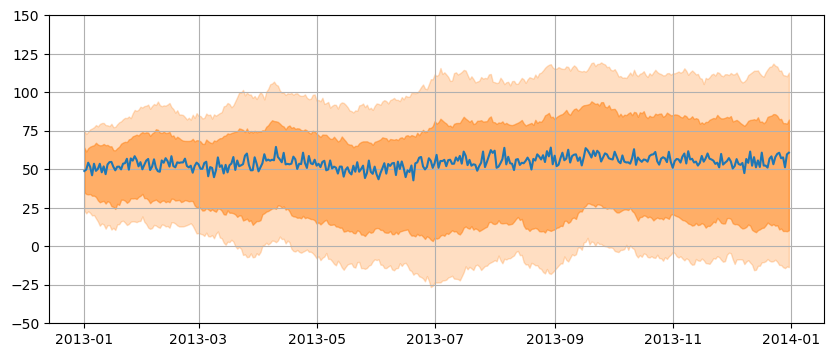

In [4]:
## Prior Predictive Check
with state_space_model:
    idata = pm.sample_prior_predictive()

fig, ax = plt.subplots(figsize=(10, 4))
quantiles = idata.prior_predictive['Y_obs'].quantile((0.11, 0.25, 0.5, 0.75, 0.89), dim=("chain", "draw")).transpose()
az.plot_hdi(
    data.index[pre_intervention],
    hdi_data=quantiles.sel(quantile=[0.11, 0.89]),
    fill_kwargs={"alpha": 0.25},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    data.index[pre_intervention],
    hdi_data=quantiles.sel(quantile=[0.25, 0.75]),
    fill_kwargs={"alpha": 0.5},
    smooth=False,
    ax=ax,
)
ax.plot(data.index[pre_intervention], idata.observed_data['Y_obs'], label="observed")
plt.ylim(-50, 150)
plt.grid()

In [5]:
# Fit the model
with state_space_model:
    idata = pm.sample(1000, tune=1000, target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_mu, mu, beta_X1, beta_X2, sigma_obs]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [6]:
# Sample In-Sample Posterior Predictive:
with state_space_model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [Y_obs]


Output()

In [27]:
# Sample Predictive Counterfactual:
with state_space_model:
    state_space_model.set_dim(name="n", new_length=N - intervention_idx, coord_values=np.arange(start=intervention_idx, stop=N))
    state_space_model.set_data("X1", data["X1"].values[post_intervention], coords={"n": np.arange(start=intervention_idx, stop=N)})
    state_space_model.set_data("X2", data["X2"].values[post_intervention], coords={"n": np.arange(start=intervention_idx, stop=N)})
    temp = data["Y"].values.copy()
    temp[post_intervention] = np.nan
    state_space_model.set_data("Y", temp[post_intervention], coords={"n": np.arange(start=intervention_idx, stop=N)})
    pm.sample_posterior_predictive(idata, predictions=True, extend_inferencedata=True)

print(mean.shape.eval(), mu.shape.eval(), X1.shape.eval(), X2.shape.eval(), Y_obs.shape.eval())


Sampling: [Y_obs, mu]


Output()

TypeError: Concatenating overlapping groups is not supported unless `dim` is defined. Valid dimensions are `chain` and `draw`. Alternatively, use extend to combine InferenceData with overlapping groups

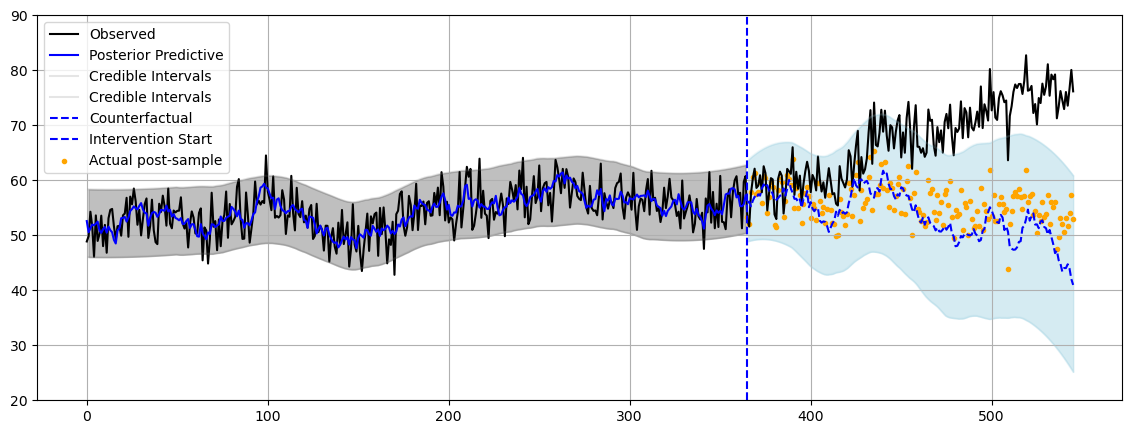

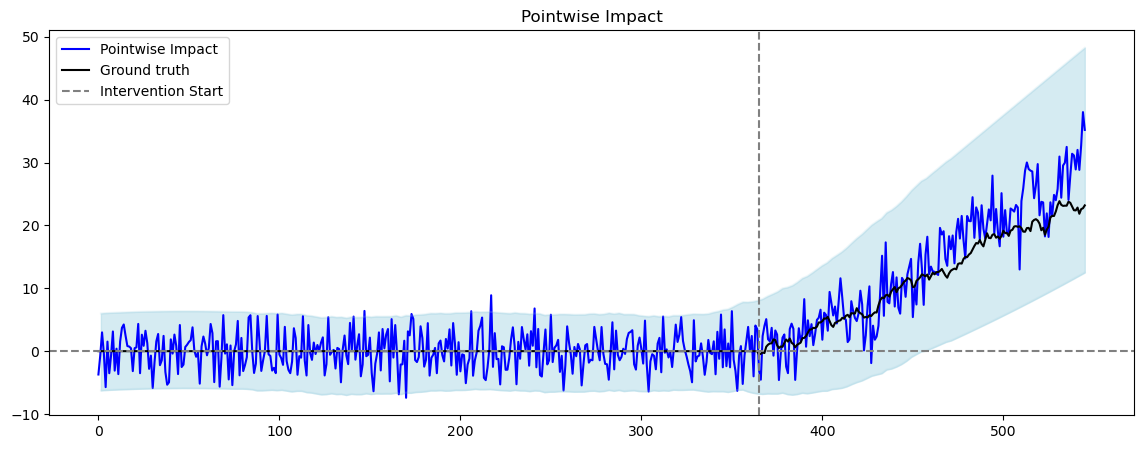

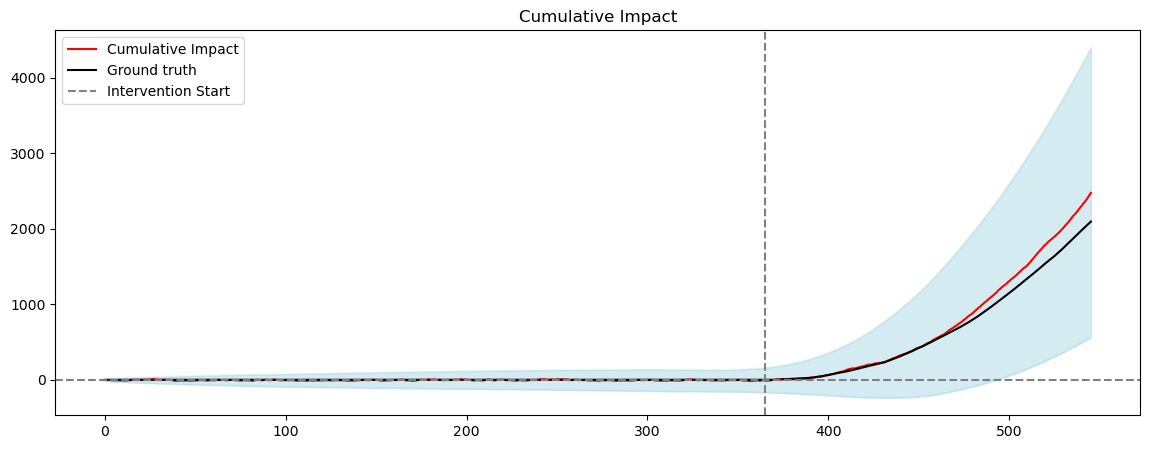

In [102]:
# Extract observed and counterfactual data
observed = data["Y"]
posterior_mean = idata.posterior_predictive["Y_obs"]#.mean(dim=["chain", "draw"])
prediction_mean = idata.predictions["Y_obs"]#.mean(dim=["chain", "draw"])
counterfactual = np.concatenate([posterior_mean.values, prediction_mean.values], axis=2)

# Compute pointwise and cumulative impact
pointwise_impact = observed.values - counterfactual
cumulative_impact = np.cumsum(pointwise_impact, axis=2)


plt.figure(figsize=(14, 5))
# Observed:
plt.plot(
    np.arange(N),
    data["Y"],
    label="Observed",
    color="black"
)
# In-Sample Posterior Predictive:
plt.plot(
    idata.observed_data["Y_obs_dim_0"],
    idata.posterior_predictive["Y_obs"].mean(dim=['chain', 'draw']),
    color='blue',
    label="Posterior Predictive"
)
az.plot_hdi(
    x=idata.observed_data["Y_obs_dim_0"],
    y=idata.posterior_predictive["Y_obs"],
    color='grey',
    plot_kwargs={"alpha": 0.2,
                 "label": "Credible Intervals",
                 }
)
# Predictions:
plt.plot(
    np.arange(N)[post_intervention],
    idata.predictions["Y_obs"].mean(dim=['chain', 'draw']),
    '--',
    color='blue',
    label="Counterfactual"
)
az.plot_hdi(
    x=np.arange(N)[post_intervention],
    y=idata.predictions["Y_obs"],
    color='lightblue',
    plot_kwargs={"alpha": 0.2}
)
plt.axvline(
    x=intervention_idx,
    color='blue',
    linestyle='--',
    label='Intervention Start'
)

# Y True:
plt.scatter(
    np.arange(N)[post_intervention],
    data["Y_true"].values[post_intervention],
    label="Actual post-sample",
    marker='.',
    color='orange'
)
plt.grid()
plt.legend()
plt.ylim(20, 90)

plt.figure(figsize=(14, 5))
plt.plot(
    np.arange(N),
    pointwise_impact.mean(axis=0).mean(axis=0),
    label="Pointwise Impact",
    color="blue")
az.plot_hdi(
    x=np.arange(N),
    y=pointwise_impact,
    color='lightblue',
    plot_kwargs={"alpha": 0.2}
)
plt.plot(
    np.arange(N),
    data["Y"] - data["Y_true"],
    color='black',
    label='Ground truth')
plt.axhline(
    y=0,
    color='grey',
    linestyle='--')
plt.axvline(
    x=intervention_idx,
    color='grey',
    linestyle='--',
    label='Intervention Start')
plt.title("Pointwise Impact")
plt.legend()


plt.figure(figsize=(14, 5))
plt.plot(
    np.arange(N),
    cumulative_impact.mean(axis=0).mean(axis=0),
    label="Cumulative Impact",
    color="red"
)
plt.plot(
    np.arange(N),
    np.cumsum(data["Y"] - data["Y_true"]),
    color='black',
    label='Ground truth')
az.plot_hdi(
    x=np.arange(N),
    y=cumulative_impact,
    color='lightblue',
    plot_kwargs={"alpha": 0.2}
)
plt.axhline(
    y=0,
    color='grey',
    linestyle='--'
)
plt.axvline(
    x=intervention_idx,
    color='grey',
    linestyle='--',
    label='Intervention Start'
)
plt.title("Cumulative Impact")
plt.legend()
plt.show()
plt.show()
